In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from scipy import stats


In [3]:
#reading in the dataset
calendar_df = pd.read_csv('./Data/calendar.csv')

# Key questions to answer
* are there any seasonal patterns in the demand for AirBnB listings in Boston?

### What are the busiest periods in Boston during a calendar year?

Getting to know the calendar dataset

In [4]:
calendar_df.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [5]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


Price column has missing values on the days when apartment is not available. </br>
For the first question, the price column is not important, so this is not taken care of at this moment.

In [6]:
#setting date column to datetime
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

#checking the range of the dates that we have in the dataset:
print('First date in the dataset: ', min(calendar_df['date']))
print('Last date in the dataset: ', max(calendar_df['date']))


First date in the dataset:  2016-09-06 00:00:00
Last date in the dataset:  2017-09-05 00:00:00


**We have one year of data, starting from 2016-09-06, ending on 2017-09-05**

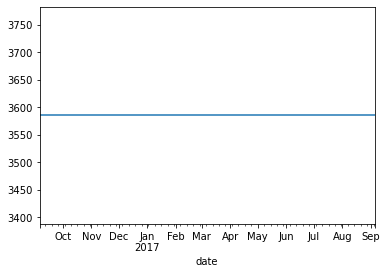

In [7]:
#counting number of distinct listings on the platfrom on each day
calendar_df.groupby('date')['listing_id'].agg('nunique').plot.line(x = 'date');

The number of available listings is constant in the dataset

In [8]:
calendar_df['listing_id'].value_counts()

12898806    730
3250739     365
11376403    365
901914      365
5270703     365
           ... 
5718921     365
951473      365
3946215     365
7540480     365
14710769    365
Name: listing_id, Length: 3585, dtype: int64

One of the listings has duplicated values: ID = 12898806 </br>
I'm removing it from the dataset:

In [9]:
#removing the listing with duplicated entries
calendar_df = calendar_df[calendar_df['listing_id'] != 12898806]

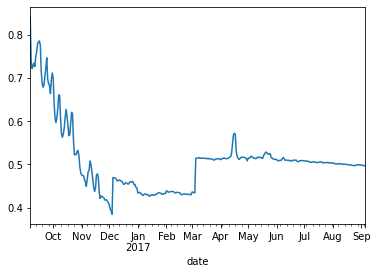

In [10]:
#counting share of booked listings on each day

(
calendar_df
 .groupby('date')['available']
    #function counting share of 'f' values among in 'available' column
 .agg(lambda x: (x=='f').sum() / len(x))
 .plot.line(x='date')
);

Some data points need to be investigated: why is the booking rate much higher in October/November 2016?
What are the big spikes of the booking rate related to? One in December (Christmas / New Yers eve?) and one in March

I found nothing suspicious in the data. </br>
Reading through a more thorough dataset explanation, it seems that availabilitiy rate may be hard to interpret. The fact that a listing is not available may mean that it's booked, or it's marked as unavailable by the owner.

Source: https://insideairbnb.com/about.html

Creating another chart, excluding period before December 2016:

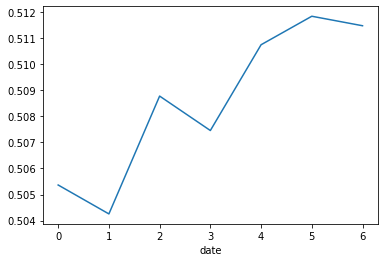

In [11]:
#counting share of booked listings on each weekday

(
calendar_df
 .groupby(calendar_df['date'].dt.strftime("%w"))['available']
    #function counting share of 'f' values in 'available' column
 .agg(lambda x: (x=='f').sum() / len(x))
 .plot.line(x='date')
);

Looking at average booking rates there seems to be a small difference between the weekdays, with Sunday and Monday (0 and 1 days) having the lowest availability rates, while Staurday and Friday have the highest ones </br>
Let's look closer at the availabilitiy distributions in weekdays to understand those differences better.
 </br> I decided to remove data voefre December 2016, as it was source of all the outliers in the distribution of availability

In [12]:
booking_rate_df = calendar_df.groupby('date')['available'].agg(lambda x: (x=='f').sum()*100 / len(x)).reset_index()

In [13]:
# adding a weekday column to the data frame with availability_rate
booking_rate_df['weekday'] = booking_rate_df['date'].dt.strftime("%a")

# removing the October - November datapoints, which were source of outliers on the first version of chart
booking_rate_since_dec = booking_rate_df[booking_rate_df['date'] >= '2016-12-01']

<Figure size 1080x1080 with 0 Axes>

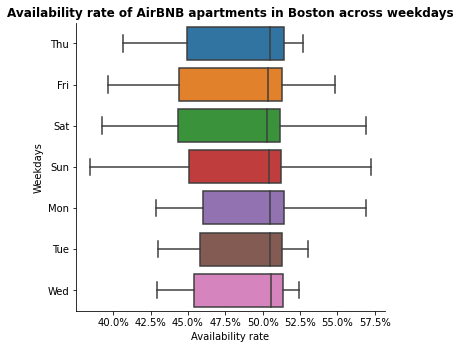

In [35]:
# plotting a boxplot of availability rate values across weekdays
plt.figure(figsize=(15, 15))
boxplot_weekdays = sns.catplot(data =booking_rate_since_dec, y= 'weekday', x='available', kind = 'box');

#setting Percent y axis formatter:
for ax in boxplot_weekdays.axes.flat:
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())

boxplot_weekdays.set(xlabel='Availability rate', ylabel='Weekdays')
boxplot_weekdays.ax.set_title("Availability rate of AirBNB apartments in Boston across weekdays",
                  fontsize=12, fontdict={"weight": "bold"}, x = 0.5, y = 1.01, wrap=True);

plt.subplots_adjust(top=0.9, bottom = 0.1)
plt.savefig('boxplot_weekday.png')
plt.show();

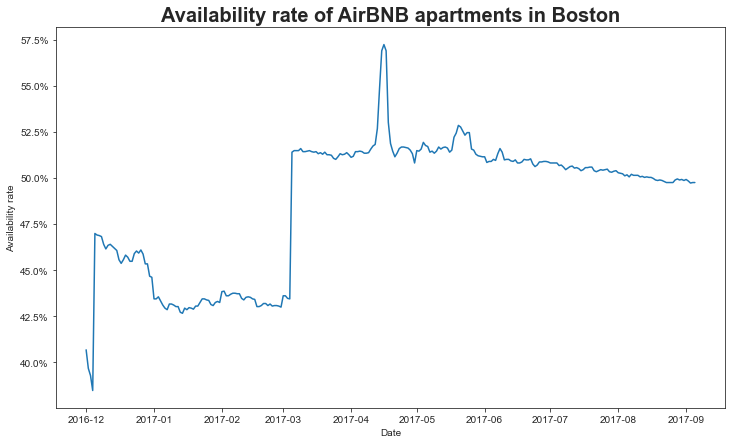

In [37]:

sns.set_style("ticks")
plt.figure(figsize=(12, 7))

availability_line_plot = sns.lineplot(data = booking_rate_since_dec, y = 'available', x = 'date');

availability_line_plot.set(xlabel='Date', ylabel='Availability rate')
# availability_line_plot.title("Availability rate of AirBNB apartments in Boston in time",
#                   fontsize=18, fontdict={"weight": "bold"}, x = 0.6, y = 1.05);

availability_line_plot.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.title("Availability rate of AirBNB apartments in Boston",
         fontsize=20, fontdict={"weight": "bold"})
plt.savefig('line_chart_availability.png')
plt.show()

The differences between weekdays do not look to be significant. There is a wide spread of obsevred values. Median and average values per weekday are simillar, close to 50%

In [775]:
#grouping the data by weekday
booking_grouped = booking_rate_since_dec.groupby('weekday')

#creating dictionary of availability rate values per weekday
weekdays_availability = {}
for name, group in booking_grouped:
    weekdays_availability[name] = group['available']

#running a Kruskal-Walis test, to see if the distirbution of availability rates differ significantly per weekday
stats.kruskal(*list(weekdays_availability.values()))

KruskalResult(statistic=1.3214852295362574, pvalue=0.9704597765833616)

Kruskal-Walis test cofnirms that there is no significant difference in avilability rate distribution across the weekdays

